# CIR Model to simulate changes in Interest rates and Liability Hedging

The Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek Model to prevent negative interest rates.

$$dr_t = a(b - r_t)dt + \sigma \sqrt{r_t} dW_t$$

* Similar to the way Brownian motion works. It models changes in the interest rates.
* Small changes that happen in the interest rate ($dr_t$) are defined by this equation.
* $r_t$ is the current interest rate
* $b$ is the long-term interest rate
* $(b - r_t)$ is the differene between the interest rate today and some long-term mean for the interest rate.
    * The gap between where interest rates are today and where they generally are in the long term is a parameters of the model. What is the long-term interest rate? 
    * The difference between those two shows you how far away you are from the long-term interest rate. 
* $a$ is a parameter that show how fast you revert to the long-term interest rate. This is known as the mean reversion speed.
    * If $a$ is zero the whole $a(b - r_t)$ term goes away. This means that the long-term mean will have no role.
    * If you have a non zero $a$, the bigger it is the faster the observed interest rate will converge to the long-term mean
* $dW_t$ is a random normal number which is scaled by $\sigma$ which is the volatility.
    * If $\sigma$ is high you will get large changes at each point in time and vice-versa.
    * If zero it will have no random effect.
* $\sqrt{r_t}$ a way to prevent negative interest rates.
    * as it tends to zero this will have no impact and chances of negative interest rates are very small.

## Short Rate vs Annualized rate of return

The short rate is the instantaneous rate you get for a very small amount of time if you borrow a sum of money just for a day. How would you compute that interest rate?

So let's assume that I give you a dollar, today, and I tell you that I'm going to charge you 100% as your interest rate. I'm going to loan it to you for a year and you have to give me back the principal, plus the interest. What does one dollar grow to at the end of one year at an interest rate of 100%?

In [2]:
1 + 1*1

2

Same interest rate, pay me twice a year.

In [3]:
1 + 1*0.5 + (1 + 1*0.5)*0.5

2.25

Let's do it 4 times a year.

In [5]:
1 + 1*0.25 + (1 + 1*0.25)*0.25 + (1 + 1*0.25 + (1 + 1*0.25)*0.25)*0.25 + (1 + 1*0.25 + (1 + 1*0.25)*0.25 + (1 + 1*0.25 + (1 + 1*0.25)*0.25)*0.25)*0.25

2.44140625

It's compounding and the interest is accruing at every single point in time

In general, if we compound every 1/N of a year (i.e. N times a year) we get:
$$\left(1 + \frac{r}{N}\right)^N$$

In [9]:
(1 + (1/4))**4

2.44140625

We can compound as many times as we like per year. For example, what if we wanted to be payed every $\frac{1}{10000}$ of a year?

In [10]:
(1+1/10000)**10000

2.7181459268249255

That number looks familiar. It's basically $e$. This is the punchline. As the amount of time between compounding decreases, the number of times increases, it converges to a particular value. As $N$ get's very large, this is the expression we get:

$$1+r_{annual} = e^{r_{inst}}$$

1 plus the annual rate is equal to $e$ to the power of the short-term or instantaneous rate.

i.e.

$$r_{annual} = e^{r_{inst}} - 1$$

and 

$$r_{inst} = ln(1 + r_{annual})$$

In [11]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import edhec_risk_kit as erk

In [12]:
def inst_to_ann(r):
    """
    Converts short rate to an annualized rate
    """
    return np.expm1(r)


def ann_to_inst(r):
    """
    Converts annualized rate to short rate
    """
    return np.log1p(r)

$$dr_t = a(b - r_t)dt + \sigma \sqrt{r_t} dW_t$$

In [14]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years * steps_per_year)+1
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b - r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

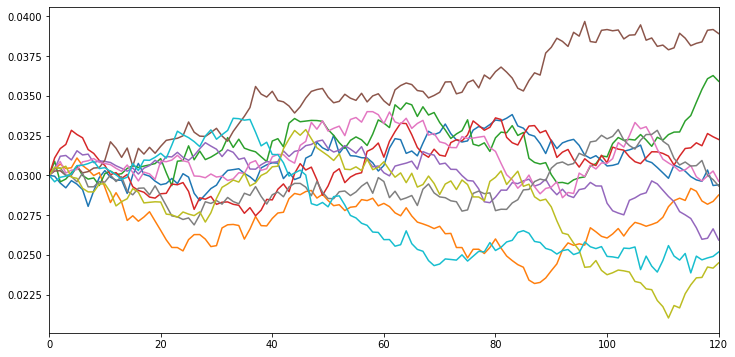

In [17]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,6), legend=False)

When interest rates change, what happens to that zero-coupon bond that we were using as a hedge?

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rates. Skipping math part because it looks intense.

In [33]:
import math

def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(loc=0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## For price generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    
    prices[0] = price(n_years, r_0)
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well
        prices[step] = price(n_years-step*dt, rates[step])
        
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ## for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    
    return rates, prices

In [34]:
import ipywidgets as widget
from IPython import display

In [35]:
def show_cir_prices(r_0): pass

In [37]:
a_0 = 0.75 # Million cash on hand
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)

# my liabilities are gonna change over time.
# The liability I want to match is $1M at the end of 10 years.
# Because the bond prices I am simulating is a zero-coupon bond, as the IR change the cost of paying off a dollar is my liability and also the bond price
liabilities = bond_prices 
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zcbond_10, r=0.03)

n_bonds = a_0/zc_0 # how many bonds can I buy
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

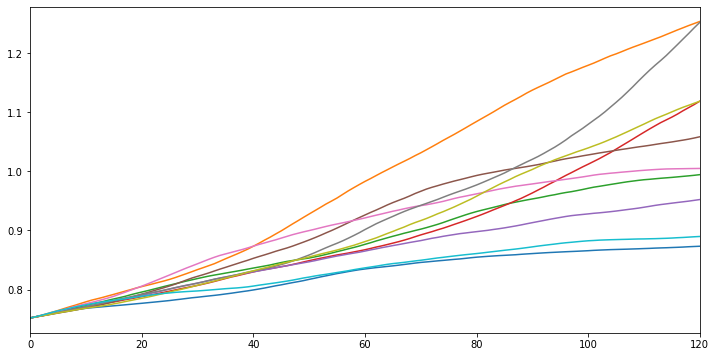

In [38]:
av_cash.plot(legend=False, figsize=(12,6))

This is the evolution of my asset value in 10 different scenario.

The liability that you're trying to match is USD1M in 10 years.

I only have USD0.75M and I'm putting it in cash as a hedge.

There are scenarios were you succed and others where you don't.

What if I put it in zero coupon bonds?

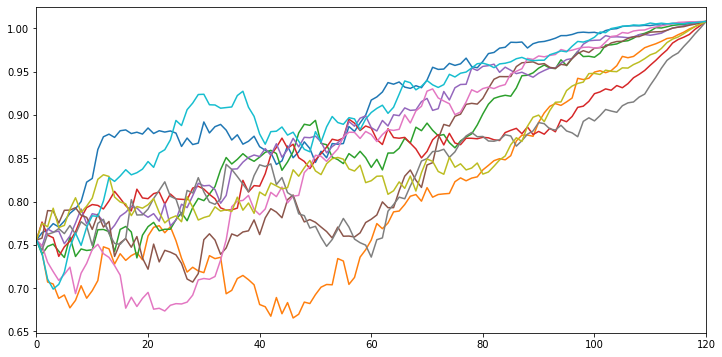

In [39]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

This looks risky but in terms of the funding ratio it is not.

I'm going to take the cash divided by liabilities. This is the funding ratio I have at any point in time and I'm going to compute the return on that funding ratio. 

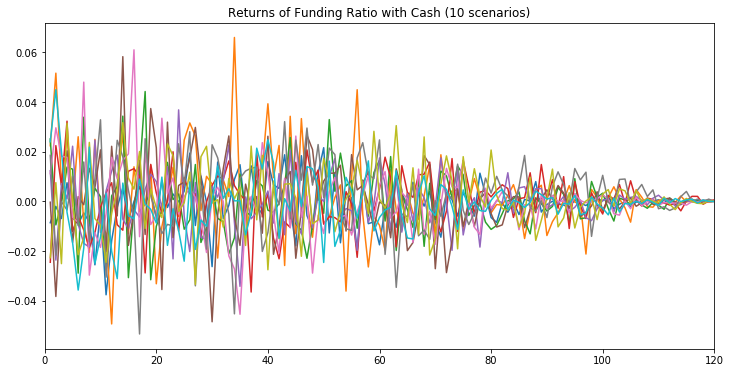

In [40]:
((av_cash/liabilities)
 .pct_change()
 .plot(title="Returns of Funding Ratio with Cash (10 scenarios)",
       legend=False, figsize=(12,6)))

In terms of the funding ratio cash is very risky.

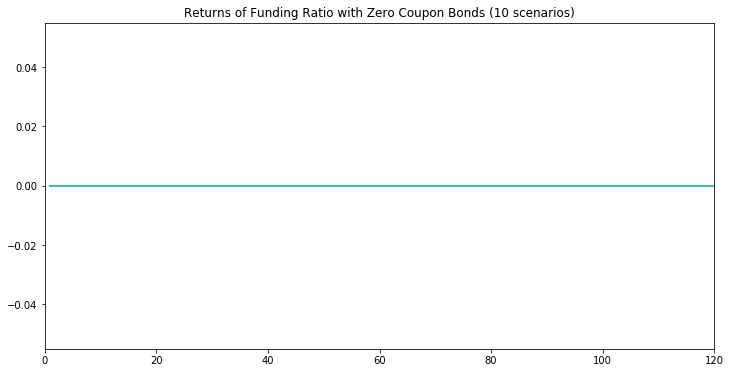

In [41]:
((av_zc_bonds/liabilities)
 .pct_change()
 .plot(title="Returns of Funding Ratio with Zero Coupon Bonds (10 scenarios)",
       legend=False, figsize=(12,6)))

Zero Coupon bonds are less sensitive to IR so you still end up where you need to end up.

In [42]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices

zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

Look at terminal funding ratios.

The last account value of my account.

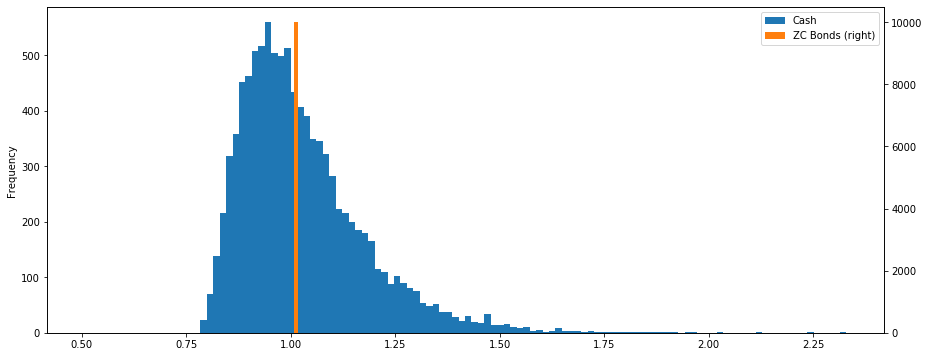

In [43]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]

ax = tfr_cash.plot.hist(label="Cash", figsize=(15,6), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label="ZC Bonds", bins=100, legend=True, secondary_y=True)

The liability here is USD 1M
Started with USD 0.75 and we have 10 years to get to USD 1M

What would happend if I put my money in cash vs zero coupon bond?

What is the spread of funding ratios?